In [47]:
import sys
import os

# Path to comma2k19 dataset
example_segment = '/Users/dimitridumont/Downloads/comma2k19/Chunk_1/b0c9d2329ad1606b|2018-07-27--06-03-57/3/'
os.listdir(example_segment) # all the files present for every minute of driving

['preview.png', 'video.hevc', 'raw_log.bz2', 'processed_log', 'global_pose']

In [48]:
import utils.orientation as orient
import utils.coordinates as coord
import numpy as np


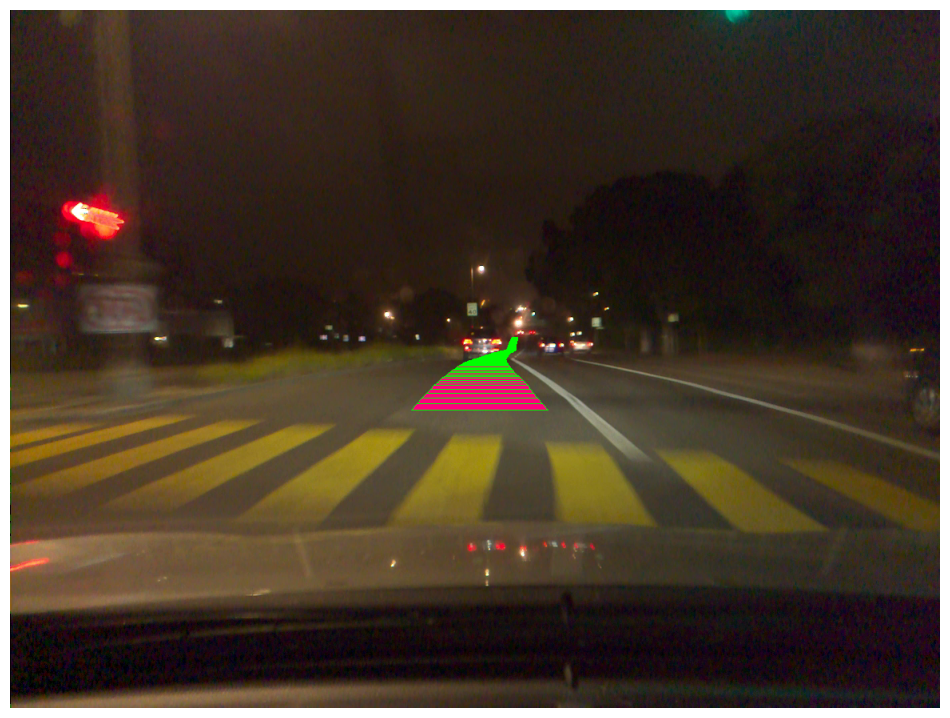

In [49]:
# We can project the path driven onto the first image
# first we convert the frame_positions to the frame
# defined by the pose of the first frame
frame_orientations = np.load(f'{example_segment}global_pose/frame_orientations')
frame_times = np.load(f'{example_segment}global_pose/frame_times')
frame_positions = np.load(f'{example_segment}global_pose/frame_positions')

ecef_from_local = orient.rot_from_quat(frame_orientations[0])
local_from_ecef = ecef_from_local.T
frame_positions_local = np.einsum('ij,kj->ki', local_from_ecef, frame_positions - frame_positions[0])

from utils.camera import img_from_device, denormalize

def draw_path(device_path, img, width=1, height=1.2, fill_color=(128, 0, 255), line_color=(0, 255, 0)):
    # Create a copy of the image to avoid altering the original
    new_img = img.copy()

    # Check if device_path is empty or None
    if device_path is None or len(device_path) == 0:
        return None
        
    device_path_l = device_path + np.array([0, 0, height])
    device_path_r = device_path + np.array([0, 0, height])
    device_path_l[:, 1] -= width
    device_path_r[:, 1] += width

    img_points_norm_l = img_from_device(device_path_l)
    img_points_norm_r = img_from_device(device_path_r)
    img_pts_l = denormalize(img_points_norm_l)
    img_pts_r = denormalize(img_points_norm_r)

    # Filter out things rejected along the way
    valid = np.logical_and(np.isfinite(img_pts_l).all(axis=1), np.isfinite(img_pts_r).all(axis=1))
    img_pts_l = img_pts_l[valid].astype(int)
    img_pts_r = img_pts_r[valid].astype(int)

    for i in range(1, len(img_pts_l)):
        u1, v1, u2, v2 = np.append(img_pts_l[i - 1], img_pts_r[i - 1])
        u3, v3, u4, v4 = np.append(img_pts_l[i], img_pts_r[i])
        pts = np.array([[u1, v1], [u2, v2], [u4, v4], [u3, v3]], np.int32).reshape((-1, 1, 2))
        cv2.fillPoly(new_img, [pts], fill_color)
        cv2.polylines(new_img, [pts], True, line_color)

    return new_img

import cv2

img = cv2.imread(f'{example_segment}preview.png')
img = draw_path(frame_positions_local[11:250], img)
# Convert BGR to RGB (cv2 uses BGR by default)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display using matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

In [50]:
import os
import shutil
import numpy as np
from PIL import Image
import cv2
from tqdm import tqdm  # For progress bar
import random


def process_segment(segment_path, output_dir, index):
    """Process a single segment and save to dataset directory"""
    try:
        # Load preview image
        preview_path = os.path.join(segment_path, 'preview.png')
        if not os.path.exists(preview_path):
            return False
            
        # Load route data
        global_pose_dir = os.path.join(segment_path, 'global_pose')
        frame_orientations = np.load(f'{global_pose_dir}/frame_orientations')
        frame_positions = np.load(f'{global_pose_dir}/frame_positions')
        
        # Create route overlay
        img = cv2.imread(preview_path)
        if img is None:  # Add check for image loading
            print(f"Failed to load image: {preview_path}")
            return False
            
        ecef_from_local = orient.rot_from_quat(frame_orientations[0])
        local_from_ecef = ecef_from_local.T
        frame_positions_local = np.einsum('ij,kj->ki', local_from_ecef, frame_positions - frame_positions[0])
        
        # Draw route on image
        route_img = draw_path(frame_positions_local[11:250], img)  
        if route_img is None:
            return False
        # Create output directory for this index if it doesn't exist
        input_dir = os.path.join(output_dir, 'input')
        output_dir = os.path.join(output_dir, 'output')
        os.makedirs(input_dir, exist_ok=True)
        os.makedirs(output_dir, exist_ok=True)
        
        _id = str(random.randint(1, 99999999))
        # Save both images
        shutil.copy2(preview_path, os.path.join(input_dir, f'input_{_id}.png'))
        cv2.imwrite(os.path.join(output_dir, f'output_{_id}.png'), route_img)
        
        return True
        
    except Exception as e:
        print(f"Error processing {segment_path}: {str(e)}")
        return False
    
def create_dataset(chunk_path, output_dir):
    """Process all segments in the chunk directory"""
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Get all segment directories
    segments = []
    for root, dirs, files in os.walk(chunk_path):
        if 'preview.png' in files and 'global_pose' in dirs:
            segments.append(root)
    
    # Process each segment
    successful = 0
    for idx, segment in enumerate(tqdm(segments), 1):
        if process_segment(segment, output_dir, idx):
            successful += 1
    
    print(f"Processed {successful} segments out of {len(segments)}")

# Usage
chunk_path = '/Users/dimitridumont/Downloads/comma2k19/Chunk_1'
output_dir = './dataset'
create_dataset(chunk_path, output_dir)

100%|██████████| 188/188 [00:07<00:00, 25.63it/s]

Processed 188 segments out of 188


In [51]:
def remove_unwanted_pairs():
    """Remove unwanted input/output pairs based on files in the 'remove' folder"""
    remove_dir = './remove'
    input_dir = './dataset/input'
    
    # Get all output file IDs from remove folder
    remove_ids = []
    for filename in os.listdir(remove_dir):
        if filename.startswith('output_') and filename.endswith('.png'):
            # Extract the number between output_ and .png
            file_id = filename.replace('output_', '').replace('.png', '')
            remove_ids.append(file_id)
    
    # Remove corresponding input files
    removed_count = 0
    for file_id in remove_ids:
        input_file = os.path.join(input_dir, f'input_{file_id}.png')
        if os.path.exists(input_file):
            os.remove(input_file)
            removed_count += 1
    
    print(f"Removed {removed_count} input files")

# Run the removal function
remove_unwanted_pairs()


Removed 24 input files
